In [1]:
%load_ext autoreload
%autoreload 1

from google.colab import drive
drive.mount("/content/drive")
# Direct to your assignment folder.
%cd /content/drive/MyDrive/Cartonomics/Cocass

Mounted at /content/drive
/content/drive/MyDrive/Cartonomics/Cocass


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Purity Score: 0.5576
NMI Score: 0.1704
ARI Score: 0.0542


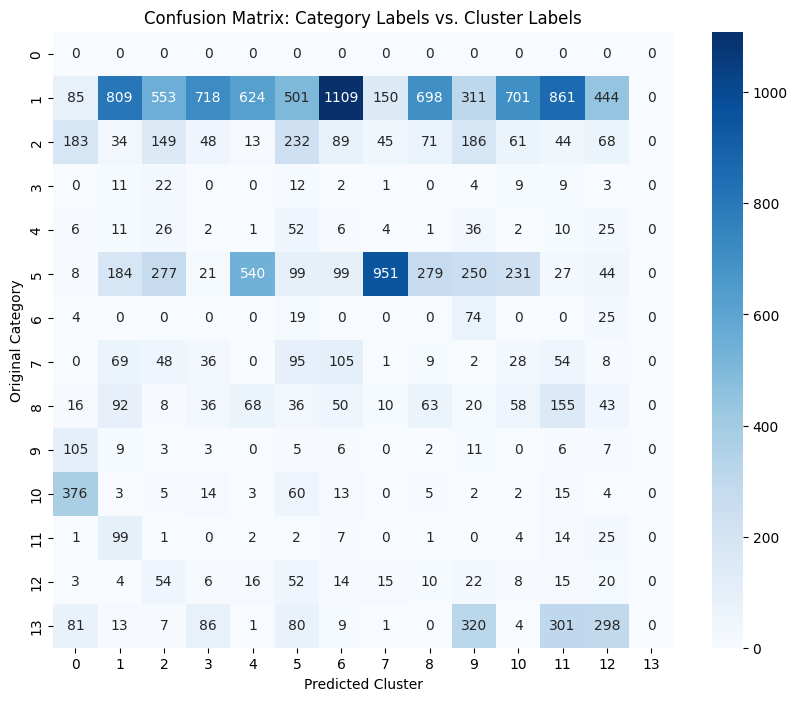

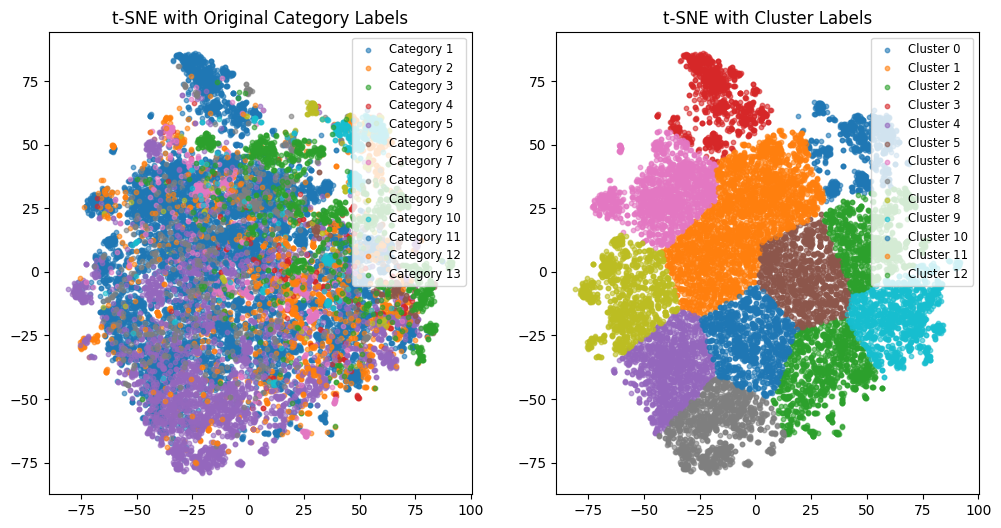

In [2]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import math
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Step 1: Load COCO Dataset
# -------------------------
class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco_data['images']}

        self.annotations = [
            ann for ann in self.coco_data['annotations']
            if 'bbox' in ann and len(ann['bbox']) == 4 and ann['bbox'][2] > 0 and ann['bbox'][3] > 0
        ]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        category_id = annotation['category_id']  # Original label

        if image_id not in self.image_id_to_filename:
            raise IndexError(f"Image ID {image_id} not found in the dataset.")

        file_name = self.image_id_to_filename[image_id]
        image_path = os.path.join(self.images_dir, file_name)

        image = Image.open(image_path).convert('RGB')
        x, y, w, h = map(int, bbox)
        cropped_image = image.crop((x, y, x + w, y + h))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, file_name, bbox, category_id

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "data/coco_datasets/train_data/train_images"
coco_json_path = "data/coco_datasets/train_data/train_annotations.json"

# -------------------------
# Step 2: Define ResNet Encoder
# -------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetEncoder, self).__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

embedding_dim = 128
model = ResNetEncoder(embedding_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# -------------------------
# Step 3: Extract Embeddings
# -------------------------
def custom_collate_fn(batch):
    images, file_names, bboxes, category_ids = zip(*batch)
    return (
        torch.stack(images),
        list(file_names),
        list(bboxes),
        list(category_ids)
    )

dataset = COCODataset(coco_json_path, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

embeddings_list = []
file_name_list = []
bbox_list = []
original_labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for images, file_names, bboxes, category_ids in dataloader:
        images = images.to(device)
        embeddings = model(images)

        for embedding, file_name, bbox, category_id in zip(embeddings.cpu().numpy(), file_names, bboxes, category_ids):
            embeddings_list.append(embedding)
            file_name_list.append(file_name)
            bbox_list.append((file_name, bbox))
            original_labels.append(category_id)

embeddings = np.array(embeddings_list)

# -------------------------
# Step 4: Apply t-SNE
# -------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced_embeddings = tsne.fit_transform(embeddings)

# -------------------------
# Step 5: Clustering
# -------------------------
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

# -------------------------
# Step 6: Evaluate Alignment
# -------------------------
def purity_score(true_labels, predicted_labels):
    cluster_assignments = {}
    for cluster_id in set(predicted_labels):
        indices = np.where(np.array(predicted_labels) == cluster_id)[0]
        true_labels_in_cluster = [true_labels[i] for i in indices]
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_assignments[cluster_id] = most_common_label

    correct = sum(
        1 for i in range(len(predicted_labels))
        if true_labels[i] == cluster_assignments[predicted_labels[i]]
    )
    return correct / len(true_labels)

purity = purity_score(original_labels, cluster_labels)
nmi = normalized_mutual_info_score(original_labels, cluster_labels)
ari = adjusted_rand_score(original_labels, cluster_labels)

print(f"Purity Score: {purity:.4f}")
print(f"NMI Score: {nmi:.4f}")
print(f"ARI Score: {ari:.4f}")

# -------------------------
# Step 7: Visualize Results
# -------------------------
# Confusion Matrix
conf_matrix = confusion_matrix(original_labels, cluster_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix: Category Labels vs. Cluster Labels')
plt.xlabel('Predicted Cluster')
plt.ylabel('Original Category')
plt.show()

# Overlay Clusters on t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for category_id in set(original_labels):
    indices = np.where(np.array(original_labels) == category_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Category {category_id}', alpha=0.6, s=10)
plt.title('t-SNE with Original Category Labels')
plt.legend(loc='best', fontsize='small')

plt.subplot(1, 2, 2)
for cluster_id in set(cluster_labels):
    indices = np.where(np.array(cluster_labels) == cluster_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Cluster {cluster_id}', alpha=0.6, s=10)
plt.title('t-SNE with Cluster Labels')
plt.legend(loc='best', fontsize='small')

plt.show()


Purity Score: 0.5576
NMI Score: 0.1704
ARI Score: 0.0542


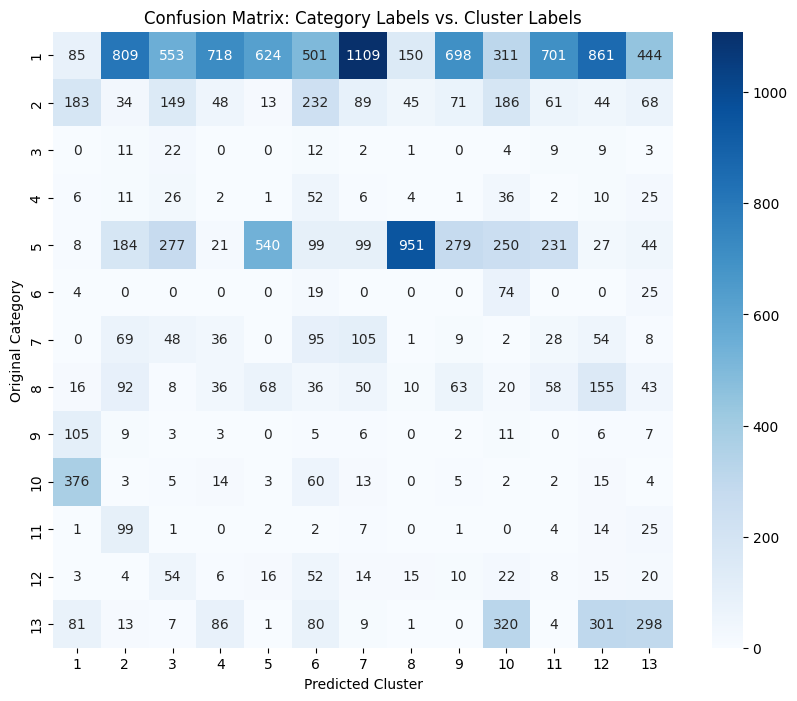

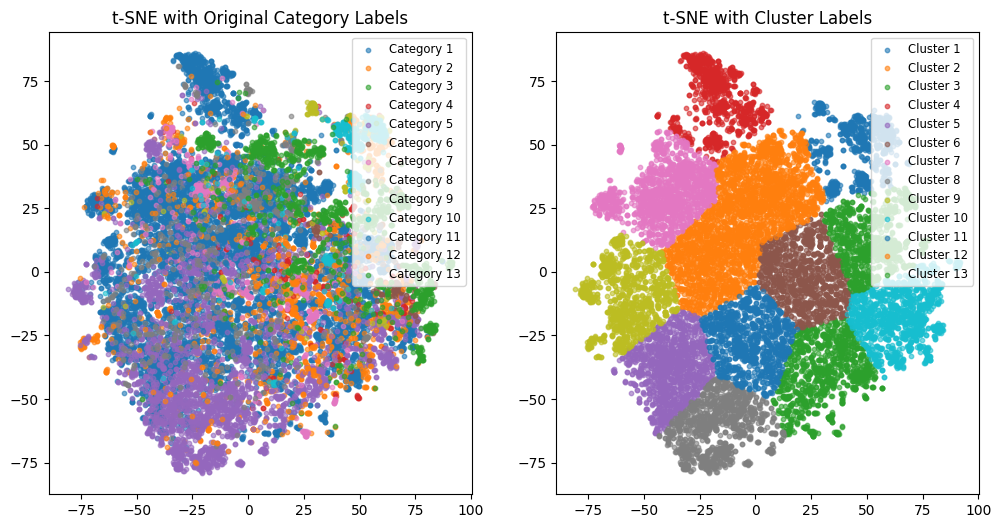

In [3]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------
# Updated Step 6: Evaluate Alignment
# -------------------------
def purity_score(true_labels, predicted_labels):
    cluster_assignments = {}
    for cluster_id in set(predicted_labels):
        indices = np.where(np.array(predicted_labels) == cluster_id)[0]
        true_labels_in_cluster = [true_labels[i] for i in indices]
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_assignments[cluster_id] = most_common_label

    correct = sum(
        1 for i in range(len(predicted_labels))
        if true_labels[i] == cluster_assignments[predicted_labels[i]]
    )
    return correct / len(true_labels)

# Adjust category and cluster labels to have the same range (1 to 13)
adjusted_cluster_labels = [label + 1 for label in cluster_labels]  # Shift cluster labels to 1-based indexing

purity = purity_score(original_labels, adjusted_cluster_labels)
nmi = normalized_mutual_info_score(original_labels, adjusted_cluster_labels)
ari = adjusted_rand_score(original_labels, adjusted_cluster_labels)

print(f"Purity Score: {purity:.4f}")
print(f"NMI Score: {nmi:.4f}")
print(f"ARI Score: {ari:.4f}")

# -------------------------
# Updated Step 7: Visualize Results
# -------------------------
# Confusion Matrix
conf_matrix = confusion_matrix(original_labels, adjusted_cluster_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 14), yticklabels=range(1, 14))
plt.title('Confusion Matrix: Category Labels vs. Cluster Labels')
plt.xlabel('Predicted Cluster')
plt.ylabel('Original Category')
plt.show()

# Overlay Clusters on t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for category_id in set(original_labels):
    indices = np.where(np.array(original_labels) == category_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Category {category_id}', alpha=0.6, s=10)
plt.title('t-SNE with Original Category Labels')
plt.legend(loc='best', fontsize='small')

plt.subplot(1, 2, 2)
for cluster_id in set(adjusted_cluster_labels):
    indices = np.where(np.array(adjusted_cluster_labels) == cluster_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Cluster {cluster_id}', alpha=0.6, s=10)
plt.title('t-SNE with Cluster Labels')
plt.legend(loc='best', fontsize='small')

plt.show()


Purity Score: 0.4894
NMI Score: 0.0097
ARI Score: 0.0027


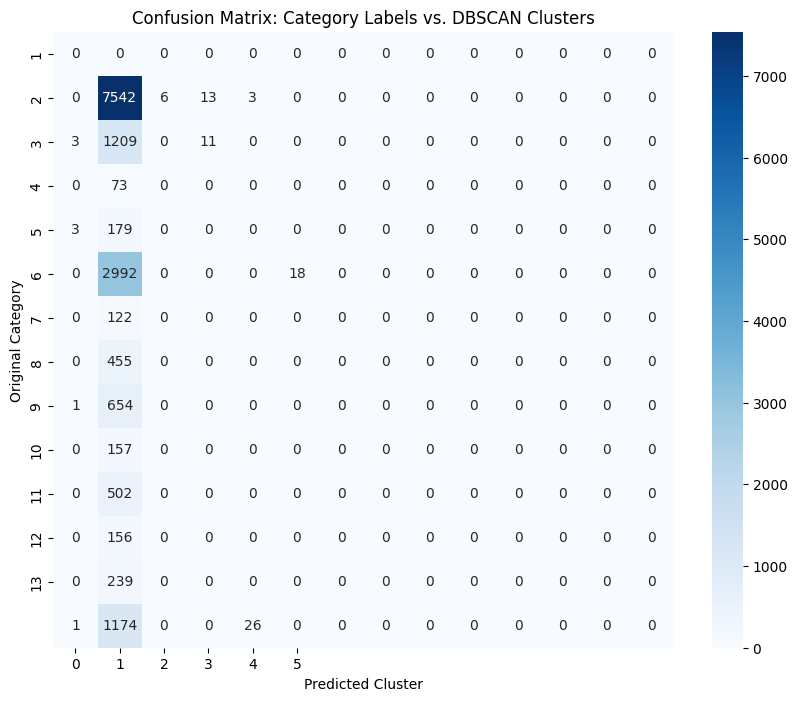

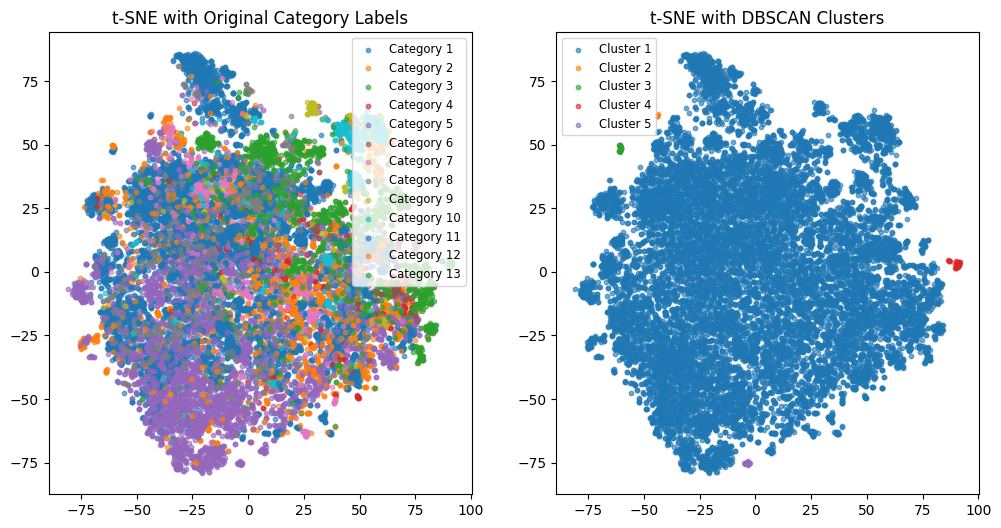

In [4]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN

# -------------------------
# Step 5: Clustering with DBSCAN
# -------------------------
# Apply DBSCAN for clustering
# Parameters: eps (distance threshold), min_samples (minimum points to form a dense cluster)
dbscan = DBSCAN(eps=5, min_samples=5, metric='euclidean')
adjusted_cluster_labels = dbscan.fit_predict(reduced_embeddings)

# Adjust cluster labels to ensure compatibility with evaluation
# DBSCAN assigns -1 to noise points, so they are treated as a separate cluster
adjusted_cluster_labels = np.array([label + 1 if label != -1 else 0 for label in adjusted_cluster_labels])

# -------------------------
# Step 6: Evaluate Alignment
# -------------------------
def purity_score(true_labels, predicted_labels):
    cluster_assignments = {}
    for cluster_id in set(predicted_labels):
        if cluster_id == 0:  # Skip noise points
            continue
        indices = np.where(np.array(predicted_labels) == cluster_id)[0]
        true_labels_in_cluster = [true_labels[i] for i in indices]
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_assignments[cluster_id] = most_common_label

    correct = sum(
        1 for i in range(len(predicted_labels))
        if predicted_labels[i] != 0 and true_labels[i] == cluster_assignments[predicted_labels[i]]
    )
    return correct / len(true_labels)

purity = purity_score(original_labels, adjusted_cluster_labels)
nmi = normalized_mutual_info_score(original_labels, adjusted_cluster_labels)
ari = adjusted_rand_score(original_labels, adjusted_cluster_labels)

print(f"Purity Score: {purity:.4f}")
print(f"NMI Score: {nmi:.4f}")
print(f"ARI Score: {ari:.4f}")

# -------------------------
# Step 7: Visualize Results
# -------------------------
# Confusion Matrix
conf_matrix = confusion_matrix(original_labels, adjusted_cluster_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, max(adjusted_cluster_labels) + 1), yticklabels=range(1, 14))
plt.title('Confusion Matrix: Category Labels vs. DBSCAN Clusters')
plt.xlabel('Predicted Cluster')
plt.ylabel('Original Category')
plt.show()

# Overlay Clusters on t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for category_id in set(original_labels):
    indices = np.where(np.array(original_labels) == category_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Category {category_id}', alpha=0.6, s=10)
plt.title('t-SNE with Original Category Labels')
plt.legend(loc='best', fontsize='small')

plt.subplot(1, 2, 2)
for cluster_id in set(adjusted_cluster_labels):
    if cluster_id == 0:  # Noise points
        continue
    indices = np.where(np.array(adjusted_cluster_labels) == cluster_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Cluster {cluster_id}', alpha=0.6, s=10)
plt.title('t-SNE with DBSCAN Clusters')
plt.legend(loc='best', fontsize='small')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Purity Score: 0.5802
NMI Score: 0.1794
ARI Score: 0.0752


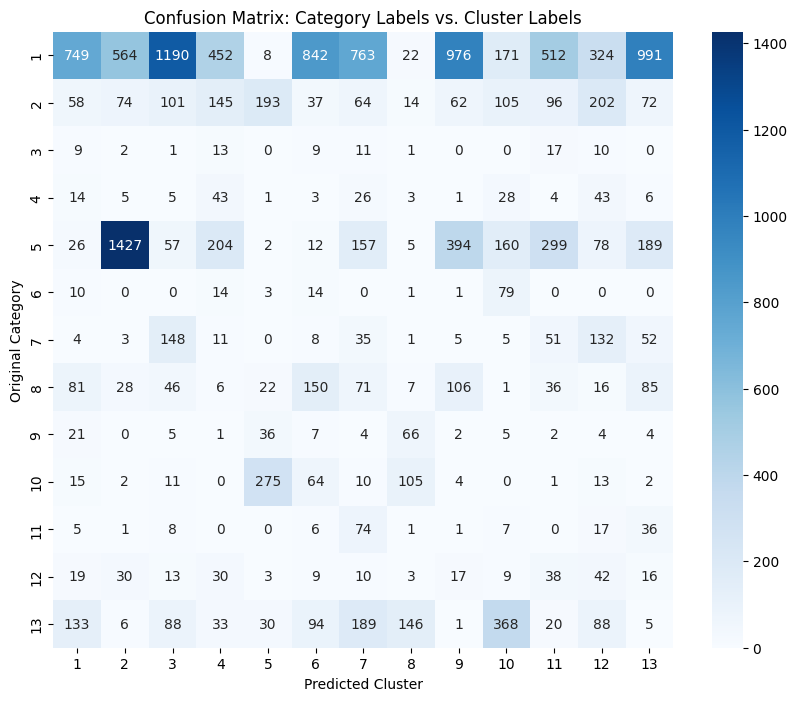

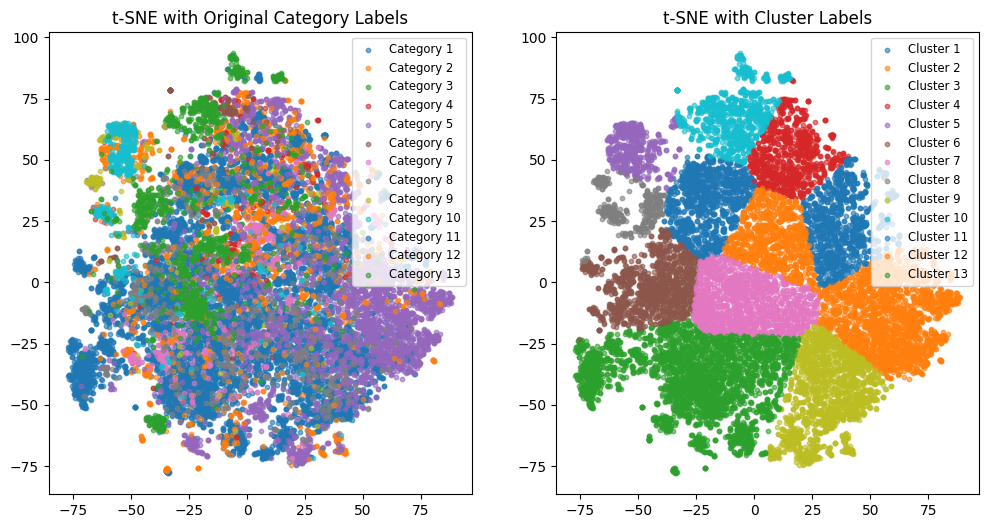

In [8]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import math
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Step 1: Load COCO Dataset
# -------------------------
class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco_data['images']}

        self.annotations = [
            ann for ann in self.coco_data['annotations']
            if 'bbox' in ann and len(ann['bbox']) == 4 and ann['bbox'][2] > 0 and ann['bbox'][3] > 0
        ]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        category_id = annotation['category_id']  # Original label

        if image_id not in self.image_id_to_filename:
            raise IndexError(f"Image ID {image_id} not found in the dataset.")

        file_name = self.image_id_to_filename[image_id]
        image_path = os.path.join(self.images_dir, file_name)

        image = Image.open(image_path).convert('RGB')
        x, y, w, h = map(int, bbox)
        cropped_image = image.crop((x, y, x + w, y + h))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, file_name, bbox, category_id

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "data/coco_datasets/train_data/train_images"
coco_json_path = "data/coco_datasets/train_data/train_annotations.json"

# -------------------------
# Step 2: Define ResNet Encoder
# -------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetEncoder, self).__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

embedding_dim = 128
model = ResNetEncoder(embedding_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# -------------------------
# Step 3: Extract Embeddings
# -------------------------
def custom_collate_fn(batch):
    images, file_names, bboxes, category_ids = zip(*batch)
    return (
        torch.stack(images),
        list(file_names),
        list(bboxes),
        list(category_ids)
    )

dataset = COCODataset(coco_json_path, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

embeddings_list = []
file_name_list = []
bbox_list = []
original_labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for images, file_names, bboxes, category_ids in dataloader:
        images = images.to(device)
        embeddings = model(images)

        for embedding, file_name, bbox, category_id in zip(embeddings.cpu().numpy(), file_names, bboxes, category_ids):
            embeddings_list.append(embedding)
            file_name_list.append(file_name)
            bbox_list.append((file_name, bbox))
            original_labels.append(category_id)

embeddings = np.array(embeddings_list)

# -------------------------
# Step 4: Apply t-SNE
# -------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced_embeddings = tsne.fit_transform(embeddings)

# -------------------------
# Step 5: Weighted Clustering
# -------------------------
unique_labels = np.array(list(set(original_labels)))  # Convert to NumPy array
weights = compute_class_weight('balanced', classes=unique_labels, y=np.array(original_labels))  # Use NumPy arrays
sample_weights = [weights[label - 1] for label in original_labels]  # Adjusting for 1-based indexing

weighted_kmeans = KMeans(n_clusters=13, random_state=42)
cluster_labels = weighted_kmeans.fit_predict(reduced_embeddings, sample_weight=sample_weights)

# -------------------------
# Step 6: Evaluate Alignment
# -------------------------
def purity_score(true_labels, predicted_labels):
    cluster_assignments = {}
    for cluster_id in set(predicted_labels):
        indices = np.where(np.array(predicted_labels) == cluster_id)[0]
        true_labels_in_cluster = [true_labels[i] for i in indices]
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_assignments[cluster_id] = most_common_label

    correct = sum(
        1 for i in range(len(predicted_labels))
        if true_labels[i] == cluster_assignments[predicted_labels[i]]
    )
    return correct / len(true_labels)

adjusted_cluster_labels = [label + 1 for label in cluster_labels]  # Shift cluster labels to 1-based indexing

purity = purity_score(original_labels, adjusted_cluster_labels)
nmi = normalized_mutual_info_score(original_labels, adjusted_cluster_labels)
ari = adjusted_rand_score(original_labels, adjusted_cluster_labels)

print(f"Purity Score: {purity:.4f}")
print(f"NMI Score: {nmi:.4f}")
print(f"ARI Score: {ari:.4f}")

# -------------------------
# Step 7: Visualize Results
# -------------------------
# Confusion Matrix
conf_matrix = confusion_matrix(original_labels, adjusted_cluster_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 14), yticklabels=range(1, 14))
plt.title('Confusion Matrix: Category Labels vs. Cluster Labels')
plt.xlabel('Predicted Cluster')
plt.ylabel('Original Category')
plt.show()

# Overlay Clusters on t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for category_id in set(original_labels):
    indices = np.where(np.array(original_labels) == category_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Category {category_id}', alpha=0.6, s=10)
plt.title('t-SNE with Original Category Labels')
plt.legend(loc='best', fontsize='small')

plt.subplot(1, 2, 2)
for cluster_id in set(adjusted_cluster_labels):
    indices = np.where(np.array(adjusted_cluster_labels) == cluster_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Cluster {cluster_id}', alpha=0.6, s=10)
plt.title('t-SNE with Cluster Labels')
plt.legend(loc='best', fontsize='small')

plt.show()

# -------------------------
# Step 8: Save Cluster Mosaics
# -------------------------
def create_cluster_mosaic(cluster_id, cluster_labels, file_name_list, bbox_list, images_dir, crop_size=(64, 64)):
    cluster_indices = [i for i, label in enumerate(cluster_labels[:len(file_name_list)]) if label == cluster_id]
    num_crops = len(cluster_indices)

    if num_crops == 0:
        raise ValueError(f"No images found for cluster {cluster_id}.")

    mosaic_cols = math.ceil(math.sqrt(num_crops))  # Number of columns
    mosaic_rows = math.ceil(num_crops / mosaic_cols)  # Number of rows

    mosaic_width = mosaic_cols * crop_size[0]
    mosaic_height = mosaic_rows * crop_size[1]
    mosaic_image = Image.new('RGB', (mosaic_width, mosaic_height), color=(255, 255, 255))

    for idx, cluster_idx in enumerate(cluster_indices):
        file_name, bbox = bbox_list[cluster_idx]
        x, y, w, h = map(int, bbox)

        image_path = os.path.join(images_dir, file_name)
        image = Image.open(image_path).convert('RGB')
        cropped_image = image.crop((x, y, x + w, y + h))
        cropped_image = cropped_image.resize(crop_size)

        row = idx // mosaic_cols
        col = idx % mosaic_cols
        x_offset = col * crop_size[0]
        y_offset = row * crop_size[1]

        mosaic_image.paste(cropped_image, (x_offset, y_offset))

    return mosaic_image

crop_size = (16, 16)
for cluster_id in range(13):
    try:
        mosaic = create_cluster_mosaic(cluster_id, cluster_labels, file_name_list, bbox_list, data_dir, crop_size)
        mosaic.save(f"train_cluster_{cluster_id}_mosaic.jpg")
    except Exception as e:
        print(f"Error creating mosaic for cluster {cluster_id}: {e}")


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Purity Score: 0.6522
NMI Score: 0.3216
ARI Score: 0.1137


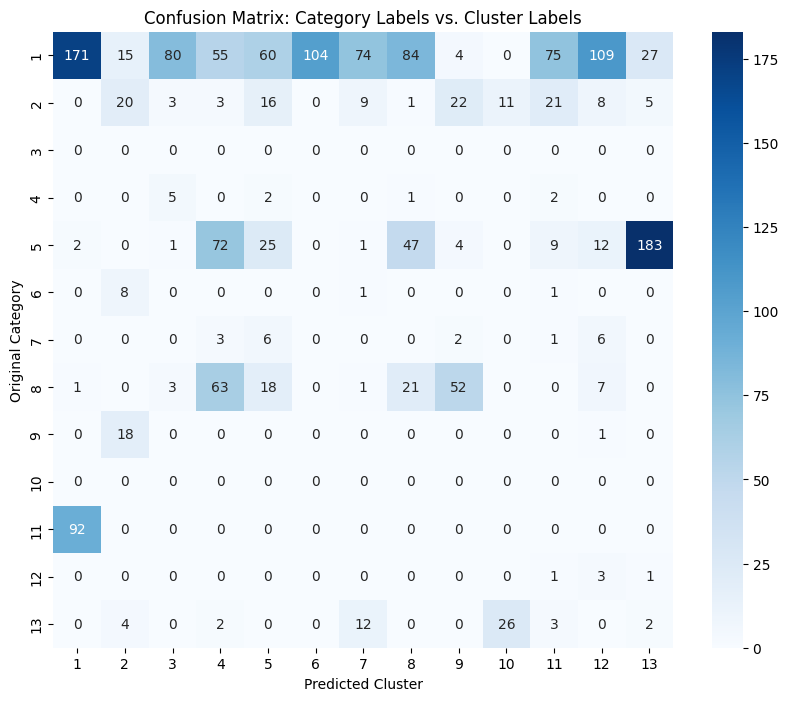

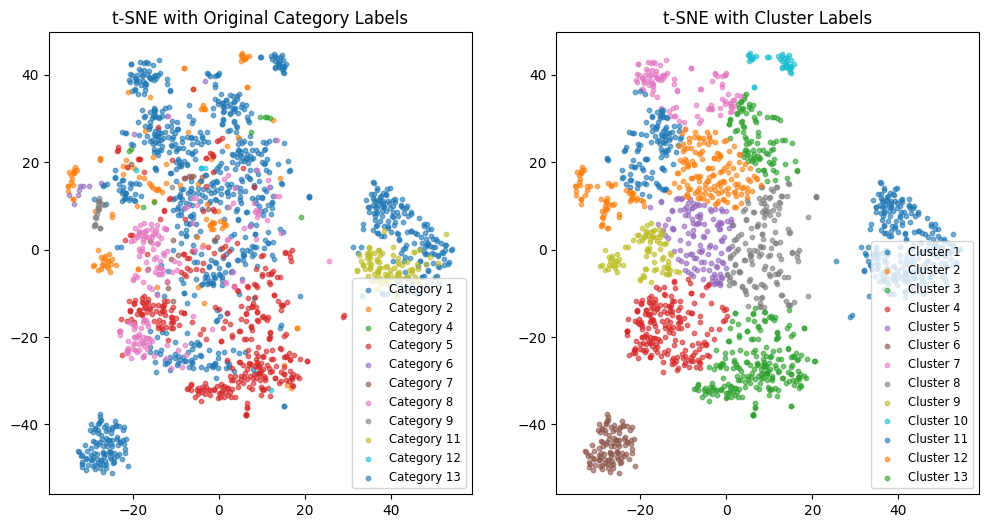

In [10]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import math
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Step 1: Load COCO Dataset
# -------------------------
class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco_data['images']}

        self.annotations = [
            ann for ann in self.coco_data['annotations']
            if 'bbox' in ann and len(ann['bbox']) == 4 and ann['bbox'][2] > 0 and ann['bbox'][3] > 0
        ]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        category_id = annotation['category_id']  # Original label

        if image_id not in self.image_id_to_filename:
            raise IndexError(f"Image ID {image_id} not found in the dataset.")

        file_name = self.image_id_to_filename[image_id]
        image_path = os.path.join(self.images_dir, file_name)

        image = Image.open(image_path).convert('RGB')
        x, y, w, h = map(int, bbox)
        cropped_image = image.crop((x, y, x + w, y + h))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, file_name, bbox, category_id

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "data/coco_datasets/test_data/test_images"
coco_json_path = "data/coco_datasets/test_data/test_annotations.json"

# -------------------------
# Step 2: Define ResNet Encoder
# -------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetEncoder, self).__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

embedding_dim = 128
model = ResNetEncoder(embedding_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# -------------------------
# Step 3: Extract Embeddings
# -------------------------
def custom_collate_fn(batch):
    images, file_names, bboxes, category_ids = zip(*batch)
    return (
        torch.stack(images),
        list(file_names),
        list(bboxes),
        list(category_ids)
    )

dataset = COCODataset(coco_json_path, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

embeddings_list = []
file_name_list = []
bbox_list = []
original_labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for images, file_names, bboxes, category_ids in dataloader:
        images = images.to(device)
        embeddings = model(images)

        for embedding, file_name, bbox, category_id in zip(embeddings.cpu().numpy(), file_names, bboxes, category_ids):
            embeddings_list.append(embedding)
            file_name_list.append(file_name)
            bbox_list.append((file_name, bbox))
            original_labels.append(category_id)

embeddings = np.array(embeddings_list)

# -------------------------
# Step 4: Apply t-SNE
# -------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced_embeddings = tsne.fit_transform(embeddings)

# -------------------------
# Step 5: Weighted Clustering
# -------------------------
# Compute class weights for the present classes
unique_labels = np.array(list(set(original_labels)))  # Convert to NumPy array
weights = compute_class_weight('balanced', classes=unique_labels, y=np.array(original_labels))

# Create a mapping from label to weight
label_to_weight = {label: weight for label, weight in zip(unique_labels, weights)}

# Assign weights for the sample using the label_to_weight dictionary
sample_weights = [label_to_weight[label] for label in original_labels]

weighted_kmeans = KMeans(n_clusters=13, random_state=42)
cluster_labels = weighted_kmeans.fit_predict(reduced_embeddings, sample_weight=sample_weights)

# -------------------------
# Step 6: Evaluate Alignment
# -------------------------
def purity_score(true_labels, predicted_labels):
    cluster_assignments = {}
    for cluster_id in set(predicted_labels):
        indices = np.where(np.array(predicted_labels) == cluster_id)[0]
        true_labels_in_cluster = [true_labels[i] for i in indices]
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_assignments[cluster_id] = most_common_label

    correct = sum(
        1 for i in range(len(predicted_labels))
        if true_labels[i] == cluster_assignments[predicted_labels[i]]
    )
    return correct / len(true_labels)

adjusted_cluster_labels = [label + 1 for label in cluster_labels]  # Shift cluster labels to 1-based indexing

purity = purity_score(original_labels, adjusted_cluster_labels)
nmi = normalized_mutual_info_score(original_labels, adjusted_cluster_labels)
ari = adjusted_rand_score(original_labels, adjusted_cluster_labels)

print(f"Purity Score: {purity:.4f}")
print(f"NMI Score: {nmi:.4f}")
print(f"ARI Score: {ari:.4f}")

# -------------------------
# Step 7: Visualize Results
# -------------------------
# Confusion Matrix
conf_matrix = confusion_matrix(original_labels, adjusted_cluster_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 14), yticklabels=range(1, 14))
plt.title('Confusion Matrix: Category Labels vs. Cluster Labels')
plt.xlabel('Predicted Cluster')
plt.ylabel('Original Category')
plt.show()

# Overlay Clusters on t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for category_id in set(original_labels):
    indices = np.where(np.array(original_labels) == category_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Category {category_id}', alpha=0.6, s=10)
plt.title('t-SNE with Original Category Labels')
plt.legend(loc='best', fontsize='small')

plt.subplot(1, 2, 2)
for cluster_id in set(adjusted_cluster_labels):
    indices = np.where(np.array(adjusted_cluster_labels) == cluster_id)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=f'Cluster {cluster_id}', alpha=0.6, s=10)
plt.title('t-SNE with Cluster Labels')
plt.legend(loc='best', fontsize='small')

plt.show()

# -------------------------
# Step 8: Save Cluster Mosaics
# -------------------------
def create_cluster_mosaic(cluster_id, cluster_labels, file_name_list, bbox_list, images_dir, crop_size=(64, 64)):
    cluster_indices = [i for i, label in enumerate(cluster_labels[:len(file_name_list)]) if label == cluster_id]
    num_crops = len(cluster_indices)

    if num_crops == 0:
        raise ValueError(f"No images found for cluster {cluster_id}.")

    mosaic_cols = math.ceil(math.sqrt(num_crops))  # Number of columns
    mosaic_rows = math.ceil(num_crops / mosaic_cols)  # Number of rows

    mosaic_width = mosaic_cols * crop_size[0]
    mosaic_height = mosaic_rows * crop_size[1]
    mosaic_image = Image.new('RGB', (mosaic_width, mosaic_height), color=(255, 255, 255))

    for idx, cluster_idx in enumerate(cluster_indices):
        file_name, bbox = bbox_list[cluster_idx]
        x, y, w, h = map(int, bbox)

        image_path = os.path.join(images_dir, file_name)
        image = Image.open(image_path).convert('RGB')
        cropped_image = image.crop((x, y, x + w, y + h))
        cropped_image = cropped_image.resize(crop_size)

        row = idx // mosaic_cols
        col = idx % mosaic_cols
        x_offset = col * crop_size[0]
        y_offset = row * crop_size[1]

        mosaic_image.paste(cropped_image, (x_offset, y_offset))

    return mosaic_image

crop_size = (16, 16)
for cluster_id in range(13):
    try:
        mosaic = create_cluster_mosaic(cluster_id, cluster_labels, file_name_list, bbox_list, data_dir, crop_size)
        mosaic.save(f"test_cluster_{cluster_id}_mosaic.jpg")
    except Exception as e:
        print(f"Error creating mosaic for cluster {cluster_id}: {e}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Purity Score: 0.3467
NMI Score: 0.2773
ARI Score: 0.1424


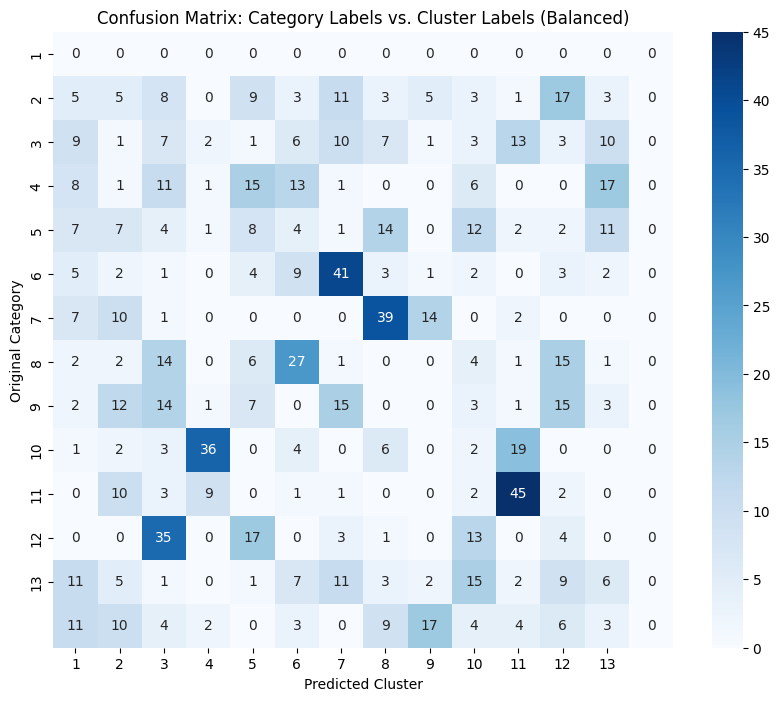

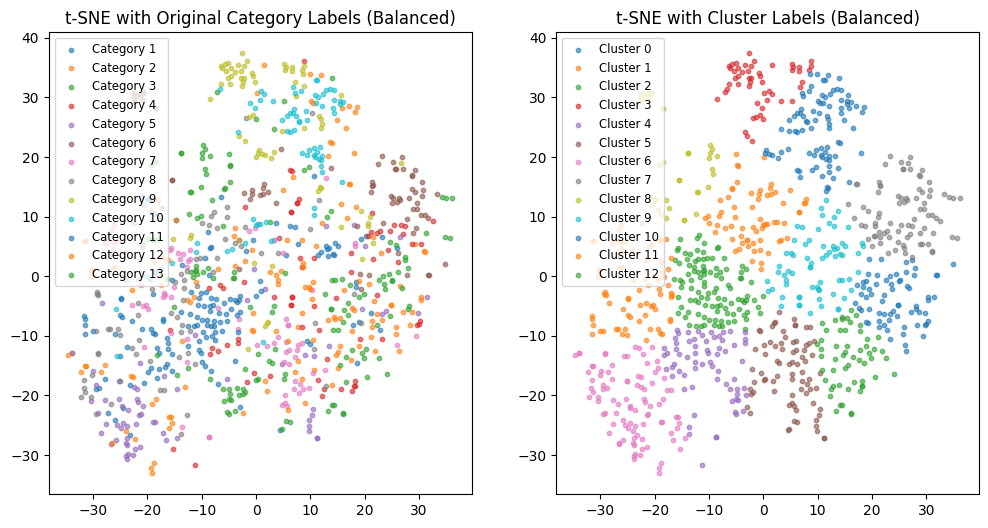

In [7]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import math
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

# -------------------------
# Step 1: Load COCO Dataset
# -------------------------
class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco_data['images']}

        self.annotations = [
            ann for ann in self.coco_data['annotations']
            if 'bbox' in ann and len(ann['bbox']) == 4 and ann['bbox'][2] > 0 and ann['bbox'][3] > 0
        ]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        category_id = annotation['category_id']  # Original label

        if image_id not in self.image_id_to_filename:
            raise IndexError(f"Image ID {image_id} not found in the dataset.")

        file_name = self.image_id_to_filename[image_id]
        image_path = os.path.join(self.images_dir, file_name)

        image = Image.open(image_path).convert('RGB')
        x, y, w, h = map(int, bbox)
        cropped_image = image.crop((x, y, x + w, y + h))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, file_name, bbox, category_id

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "data/coco_datasets/train_data/train_images"
coco_json_path = "data/coco_datasets/train_data/train_annotations.json"

# -------------------------
# Step 2: Define ResNet Encoder
# -------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetEncoder, self).__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

embedding_dim = 128
model = ResNetEncoder(embedding_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# -------------------------
# Step 3: Extract Embeddings
# -------------------------
def custom_collate_fn(batch):
    images, file_names, bboxes, category_ids = zip(*batch)
    return (
        torch.stack(images),
        list(file_names),
        list(bboxes),
        list(category_ids)
    )

dataset = COCODataset(coco_json_path, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

embeddings_list = []
file_name_list = []
bbox_list = []
original_labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for images, file_names, bboxes, category_ids in dataloader:
        images = images.to(device)
        embeddings = model(images)

        for embedding, file_name, bbox, category_id in zip(embeddings.cpu().numpy(), file_names, bboxes, category_ids):
            embeddings_list.append(embedding)
            file_name_list.append(file_name)
            bbox_list.append((file_name, bbox))
            original_labels.append(category_id)

embeddings = np.array(embeddings_list)

# -------------------------
# Step 4: Apply Downsampling
# -------------------------
# Downsample the dominant labels to balance the dataset
undersampler = RandomUnderSampler(random_state=42)
embeddings_balanced, labels_balanced = undersampler.fit_resample(embeddings, original_labels)

# -------------------------
# Step 5: Apply t-SNE
# -------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced_embeddings_balanced = tsne.fit_transform(embeddings_balanced)

# -------------------------
# Step 6: Clustering
# -------------------------
kmeans = KMeans(n_clusters=13, random_state=42)
cluster_labels_balanced = kmeans.fit_predict(reduced_embeddings_balanced)

# -------------------------
# Step 7: Evaluate Alignment
# -------------------------
def purity_score(true_labels, predicted_labels):
    cluster_assignments = {}
    for cluster_id in set(predicted_labels):
        indices = np.where(np.array(predicted_labels) == cluster_id)[0]
        true_labels_in_cluster = [true_labels[i] for i in indices]
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_assignments[cluster_id] = most_common_label

    correct = sum(
        1 for i in range(len(predicted_labels))
        if true_labels[i] == cluster_assignments[predicted_labels[i]]
    )
    return correct / len(true_labels)

purity = purity_score(labels_balanced, cluster_labels_balanced)
nmi = normalized_mutual_info_score(labels_balanced, cluster_labels_balanced)
ari = adjusted_rand_score(labels_balanced, cluster_labels_balanced)

print(f"Purity Score: {purity:.4f}")
print(f"NMI Score: {nmi:.4f}")
print(f"ARI Score: {ari:.4f}")

# -------------------------
# Step 8: Visualize Results
# -------------------------
# Confusion Matrix
conf_matrix_balanced = confusion_matrix(labels_balanced, cluster_labels_balanced)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 14), yticklabels=range(1, 14))
plt.title('Confusion Matrix: Category Labels vs. Cluster Labels (Balanced)')
plt.xlabel('Predicted Cluster')
plt.ylabel('Original Category')
plt.show()

# Overlay Clusters on t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for category_id in set(labels_balanced):
    indices = np.where(np.array(labels_balanced) == category_id)[0]
    plt.scatter(reduced_embeddings_balanced[indices, 0], reduced_embeddings_balanced[indices, 1], label=f'Category {category_id}', alpha=0.6, s=10)
plt.title('t-SNE with Original Category Labels (Balanced)')
plt.legend(loc='best', fontsize='small')

plt.subplot(1, 2, 2)
for cluster_id in set(cluster_labels_balanced):
    indices = np.where(np.array(cluster_labels_balanced) == cluster_id)[0]
    plt.scatter(reduced_embeddings_balanced[indices, 0], reduced_embeddings_balanced[indices, 1], label=f'Cluster {cluster_id}', alpha=0.6, s=10)
plt.title('t-SNE with Cluster Labels (Balanced)')
plt.legend(loc='best', fontsize='small')

plt.show()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


Embeddings shape: (15539, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completed. Reduced embeddings shape: (15539, 2)
Clustering completed. Number of clusters: 13


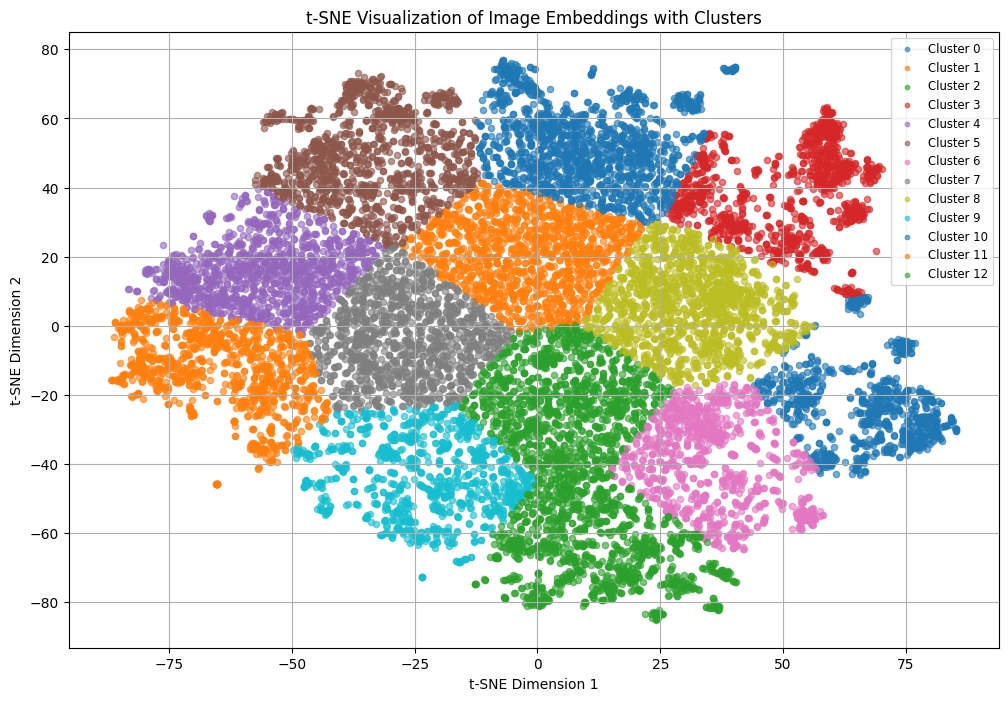

In [ ]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import math
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# -------------------------
# Step 1: Load COCO Dataset
# -------------------------
class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        # Map image IDs to file names
        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco_data['images']}

        # Filter valid annotations
        self.annotations = [
            ann for ann in self.coco_data['annotations']
            if 'bbox' in ann and len(ann['bbox']) == 4 and ann['bbox'][2] > 0 and ann['bbox'][3] > 0
        ]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        bbox = annotation['bbox']  # COCO format: [x, y, width, height]

        # Check if the image_id exists in the dataset
        if image_id not in self.image_id_to_filename:
            raise IndexError(f"Image ID {image_id} not found in the dataset.")

        file_name = self.image_id_to_filename[image_id]
        image_path = os.path.join(self.images_dir, file_name)

        # Load image and crop based on bbox
        image = Image.open(image_path).convert('RGB')
        x, y, w, h = map(int, bbox)
        cropped_image = image.crop((x, y, x + w, y + h))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, file_name, bbox

# Define dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "data/coco_datasets/train_data/train_images"
coco_json_path = "data/coco_datasets/train_data/train_annotations.json"

# -------------------------
# Step 2: Define ResNet Encoder
# -------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetEncoder, self).__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer
        self.fc = nn.Linear(512, embedding_dim)  # Adjust for ResNet18's output size

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Load model
embedding_dim = 128
model = ResNetEncoder(embedding_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Inference mode

# -------------------------
# Step 3: Extract Embeddings
# -------------------------
# Custom collate function for DataLoader
def custom_collate_fn(batch):
    images, file_names, bboxes = zip(*batch)
    return (
        torch.stack(images),  # Stack images as tensors
        list(file_names),     # Keep file names as a list
        list(bboxes)          # Keep bboxes as a list
    )

# Dataset and DataLoader
dataset = COCODataset(coco_json_path, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

embeddings_list = []
file_name_list = []
bbox_list = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for images, file_names, bboxes in dataloader:
        images = images.to(device)
        embeddings = model(images)

        for embedding, file_name, bbox in zip(embeddings.cpu().numpy(), file_names, bboxes):
            embeddings_list.append(embedding)
            file_name_list.append(file_name)
            bbox_list.append((file_name, bbox))  # Save both filename and bbox

# Convert embeddings to numpy array
embeddings = np.array(embeddings_list)
print(f"Embeddings shape: {embeddings.shape}")

# -------------------------
# Step 4: Apply t-SNE
# -------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced_embeddings = tsne.fit_transform(embeddings)
print(f"t-SNE completed. Reduced embeddings shape: {reduced_embeddings.shape}")



# -------------------------
# Step 5: Clustering
# -------------------------
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)
print(f"Clustering completed. Number of clusters: {num_clusters}")

# -------------------------
# Step 4.1: Visualize t-SNE Results with Clusters
# -------------------------
def visualize_tsne_with_clusters(reduced_embeddings, cluster_labels, num_clusters):
    plt.figure(figsize=(12, 8))

    # Loop through each cluster to plot points in different colors
    for cluster_id in range(num_clusters):
        cluster_points = reduced_embeddings[np.array(cluster_labels) == cluster_id]
        plt.scatter(
            cluster_points[:, 0], cluster_points[:, 1],
            label=f'Cluster {cluster_id}', alpha=0.6, s=20  # Adjust size and transparency
        )

    # Add plot title, legend, and axis labels
    plt.title('t-SNE Visualization of Image Embeddings with Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(loc='best', fontsize='small', markerscale=0.7)
    plt.grid(True)

    # Show the plot
    plt.show()

# Visualize the t-SNE results with clusters
visualize_tsne_with_clusters(reduced_embeddings, cluster_labels, num_clusters)


# -------------------------
# Step 6: Create Cluster Mosaics
# -------------------------
def create_cluster_mosaic(cluster_id, cluster_labels, file_name_list, bbox_list, images_dir, crop_size=(64, 64)):
    cluster_indices = [i for i, label in enumerate(cluster_labels[:len(file_name_list)]) if label == cluster_id]
    num_crops = len(cluster_indices)

    if num_crops == 0:
        raise ValueError(f"No images found for cluster {cluster_id}.")

    mosaic_cols = math.ceil(math.sqrt(num_crops))  # Number of columns
    mosaic_rows = math.ceil(num_crops / mosaic_cols)  # Number of rows

    mosaic_width = mosaic_cols * crop_size[0]
    mosaic_height = mosaic_rows * crop_size[1]
    mosaic_image = Image.new('RGB', (mosaic_width, mosaic_height), color=(255, 255, 255))

    for idx, cluster_idx in enumerate(cluster_indices):
        file_name, bbox = bbox_list[cluster_idx]
        x, y, w, h = map(int, bbox)

        image_path = os.path.join(images_dir, file_name)
        image = Image.open(image_path).convert('RGB')
        cropped_image = image.crop((x, y, x + w, y + h))
        cropped_image = cropped_image.resize(crop_size)

        row = idx // mosaic_cols
        col = idx % mosaic_cols
        x_offset = col * crop_size[0]
        y_offset = row * crop_size[1]

        mosaic_image.paste(cropped_image, (x_offset, y_offset))

    return mosaic_image

# Visualize each cluster
crop_size = (16, 16)
for cluster_id in range(num_clusters):
    try:
        mosaic = create_cluster_mosaic(cluster_id, cluster_labels, file_name_list, bbox_list, data_dir, crop_size)
        mosaic.show()
        mosaic.save(f"train_cluster_{cluster_id}_mosaic.jpg")
    except Exception as e:
        print(f"Error creating mosaic for cluster {cluster_id}: {e}")


In [ ]:
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=5, alpha=0.7, label=f"Cluster {cluster + 1}")
plt.legend()
plt.title("t-SNE with Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Embeddings shape: (15539, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completed. Reduced embeddings shape: (15539, 2)


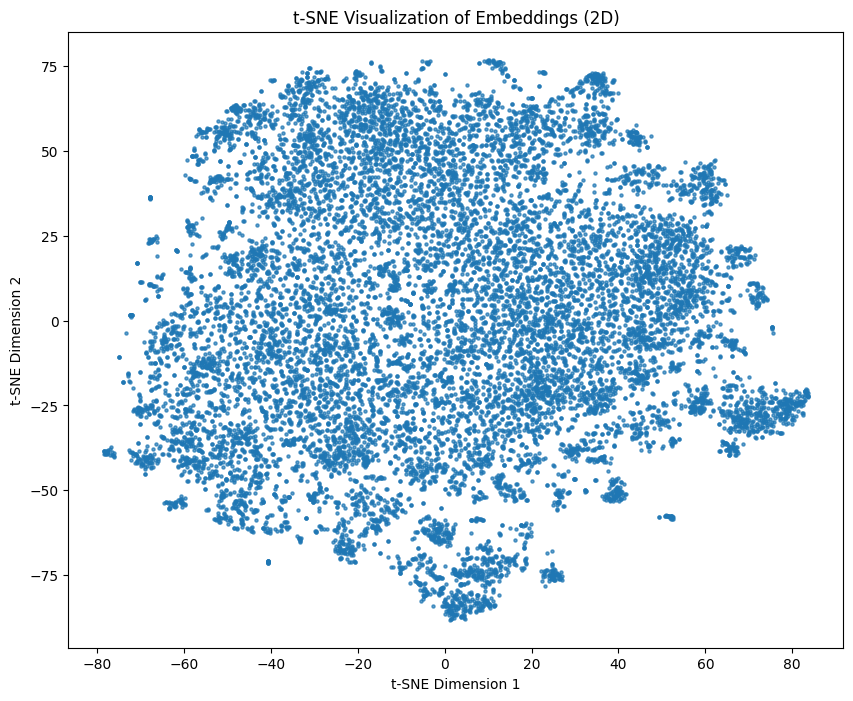

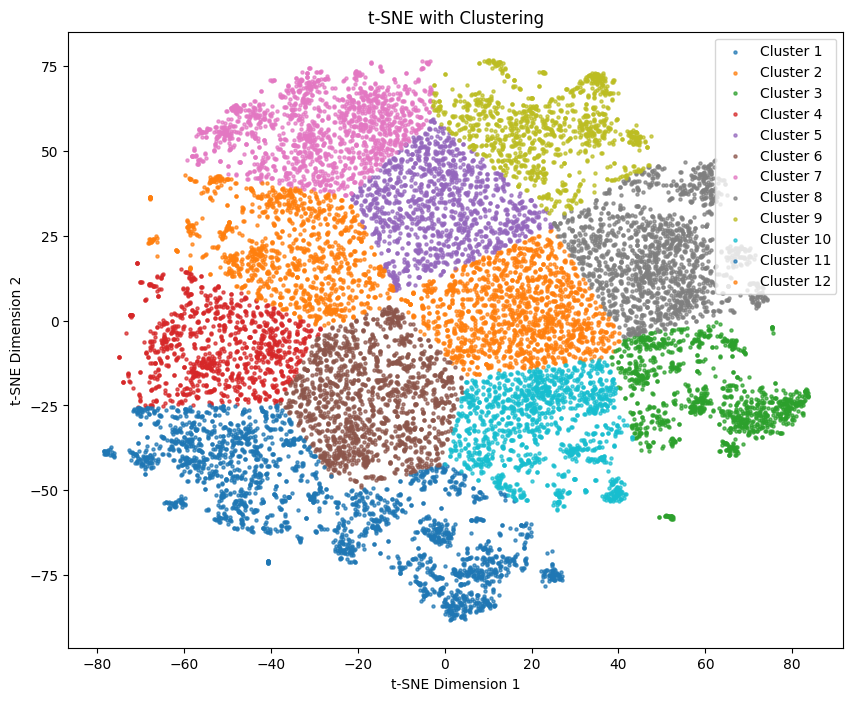

Error processing index 396 for cluster 0: num must be an integer with 1 <= num <= 20, not 21
Error processing index 397 for cluster 0: num must be an integer with 1 <= num <= 20, not 22
Error processing index 398 for cluster 0: num must be an integer with 1 <= num <= 20, not 23
Error processing index 399 for cluster 0: num must be an integer with 1 <= num <= 20, not 24
Error processing index 401 for cluster 0: num must be an integer with 1 <= num <= 20, not 25
Error processing index 402 for cluster 0: num must be an integer with 1 <= num <= 20, not 26
Error processing index 403 for cluster 0: num must be an integer with 1 <= num <= 20, not 27
Error processing index 404 for cluster 0: num must be an integer with 1 <= num <= 20, not 28
Error processing index 405 for cluster 0: num must be an integer with 1 <= num <= 20, not 29
Error processing index 406 for cluster 0: num must be an integer with 1 <= num <= 20, not 30
Error processing index 407 for cluster 0: num must be an integer with 

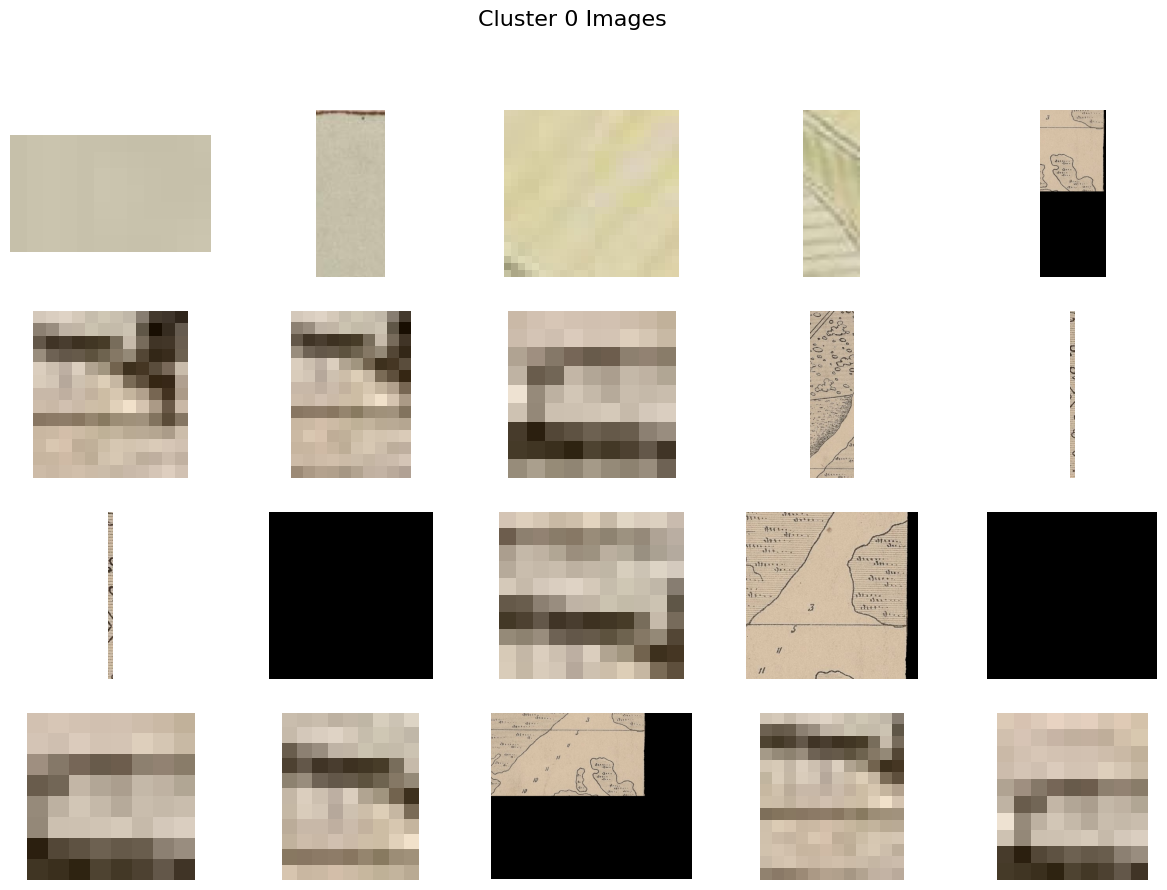

In [ ]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -------------------------
# Step 1: Load COCO Dataset
# -------------------------
class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        # Map image IDs to file names
        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco_data['images']}
        self.annotations = self.coco_data['annotations']

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        bbox = annotation['bbox']  # COCO format: [x, y, width, height]
        file_name = self.image_id_to_filename[image_id]
        image_path = os.path.join(self.images_dir, file_name)

        # Load image and crop based on bbox
        image = Image.open(image_path).convert('RGB')
        x, y, w, h = map(int, bbox)
        cropped_image = image.crop((x, y, x + w, y + h))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, file_name, bbox

# Define dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "data/coco_datasets/train_data/train_images"
coco_json = "data/coco_datasets/train_data/train_annotations.json"
dataset = COCODataset(coco_json, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# -------------------------
# Step 2: Define ResNet Autoencoder
# -------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetEncoder, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer
        self.fc = nn.Linear(512, embedding_dim)  # Adjust for ResNet18's output size

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(embedding_dim, 512 * 1 * 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 512, 1, 1)  # Reshape for ConvTranspose
        x = self.decoder(x)
        return x

class ResNetAutoencoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetAutoencoder, self).__init__()
        self.encoder = ResNetEncoder(embedding_dim)
        self.decoder = Decoder(embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Load model
embedding_dim = 128
model = ResNetAutoencoder(embedding_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Inference mode

# -------------------------
# Step 3: Extract Embeddings
# -------------------------
embeddings_list = []
valid_file_name_list = []
valid_bbox_list = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for images, file_names, bboxes in dataloader:
        images = images.to(device)
        _, embeddings = model(images)  # Get embeddings from encoder
        embeddings_list.append(embeddings.cpu().numpy())
        valid_file_name_list.extend(file_names)  # Track valid file names
        valid_bbox_list.extend(bboxes)  # Track valid bounding boxes

embeddings = np.vstack(embeddings_list)  # Combine all embeddings
print(f"Embeddings shape: {embeddings.shape}")

# -------------------------
# Step 4: Apply t-SNE
# -------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced_embeddings = tsne.fit_transform(embeddings)
print(f"t-SNE completed. Reduced embeddings shape: {reduced_embeddings.shape}")

# -------------------------
# Step 5: Visualize t-SNE Results
# -------------------------
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Embeddings (2D)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# -------------------------
# Step 6: Clustering (Optional)
# -------------------------
num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=5, alpha=0.7, label=f"Cluster {cluster + 1}")
plt.legend()
plt.title("t-SNE with Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# -------------------------
# Step 7: Display Images in a Cluster
# -------------------------
def show_cluster_images(cluster_id, cluster_labels, file_name_list, bbox_list, images_dir, max_images=50):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_indices = cluster_indices[:max_images]  # Limit to max_images

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(cluster_indices):
        try:
            file_name = file_name_list[idx]
            bbox = bbox_list[idx]

            # Ensure bbox contains exactly four values
            if len(bbox) > 4:
                bbox = bbox[:4]  # Trim to first four values
            x, y, w, h = map(int, bbox)

            image_path = os.path.join(images_dir, file_name)

            # Load and crop the image
            image = Image.open(image_path).convert('RGB')
            cropped_image = image.crop((x, y, x + w, y + h))

            # Show the image
            plt.subplot(4, 5, i + 1)
            plt.imshow(cropped_image)
            plt.axis('off')
        except Exception as e:
            print(f"Error processing index {idx} for cluster {cluster_id}: {e}")
    plt.suptitle(f"Cluster {cluster_id} Images", fontsize=16)
    plt.show()

# -------------------------
# Step 8: Create Mosaic for a Cluster
# -------------------------
def create_cluster_mosaic(cluster_id, cluster_labels, file_name_list, bbox_list, images_dir, mosaic_size=(5, 5), image_size=(64, 64)):
    """
    Create a mosaic collage of cropped images for a specific cluster.

    Args:
        cluster_id (int): The cluster ID to visualize.
        cluster_labels (array-like): Cluster labels for all embeddings.
        file_name_list (list): List of file names corresponding to each data point.
        bbox_list (list): List of bounding boxes corresponding to each data point.
        images_dir (str): Directory containing the images.
        mosaic_size (tuple): Grid size for the mosaic (rows, cols).
        image_size (tuple): Size of each cropped image in the mosaic.

    Returns:
        PIL.Image: The mosaic collage as a PIL image.
    """
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    max_images = mosaic_size[0] * mosaic_size[1]
    cluster_indices = cluster_indices[:max_images]  # Limit to the maximum number of grid cells

    # Create a blank canvas for the mosaic
    mosaic_width = mosaic_size[1] * image_size[0]
    mosaic_height = mosaic_size[0] * image_size[1]
    mosaic_image = Image.new('RGB', (mosaic_width, mosaic_height), color=(255, 255, 255))

    # Fill the mosaic grid
    for idx, cluster_idx in enumerate(cluster_indices):
        try:
            file_name = file_name_list[cluster_idx]
            bboxes = bbox_list[cluster_idx]

            # Convert bounding boxes to NumPy if necessary
            if isinstance(bboxes, torch.Tensor):
                bboxes = bboxes.numpy()

            # Process only the first bounding box (you can customize this if needed)
            bbox = bboxes.reshape(-1, 4)[0]
            x, y, w, h = map(int, bbox)

            image_path = os.path.join(images_dir, file_name)
            image = Image.open(image_path).convert('RGB')
            cropped_image = image.crop((x, y, x + w, y + h))
            cropped_image = cropped_image.resize(image_size)  # Resize to fit the mosaic grid

            # Calculate grid position
            row = idx // mosaic_size[1]
            col = idx % mosaic_size[1]
            x_offset = col * image_size[0]
            y_offset = row * image_size[1]

            # Paste the cropped image into the mosaic
            mosaic_image.paste(cropped_image, (x_offset, y_offset))
        except Exception as e:
            print(f"Error processing image {idx} in cluster {cluster_id}: {e}")
            continue

    return mosaic_image

# Example: Show images in cluster 0
show_cluster_images(cluster_id=0, cluster_labels=cluster_labels, file_name_list=valid_file_name_list,
                    bbox_list=valid_bbox_list, images_dir=data_dir, max_images=50)

# Example: Create a mosaic for cluster 0
mosaic = create_cluster_mosaic(cluster_id=0,
                               cluster_labels=cluster_labels,
                               file_name_list=valid_file_name_list,
                               bbox_list=valid_bbox_list,
                               images_dir=data_dir,
                               mosaic_size=(5, 5),  # 5x5 grid
                               image_size=(64, 64))  # Each image 64x64

# Display the mosaic
mosaic.show()

# Optionally, save the mosaic to a file
mosaic.save(f"cluster_{0}_mosaic.jpg")


In [ ]:
show_cluster_images(cluster_id=2, cluster_labels=cluster_labels, file_name_list=valid_file_name_list,
                    bbox_list=valid_bbox_list, images_dir=data_dir, max_images=50)

# Example: Create a mosaic for cluster 0
mosaic = create_cluster_mosaic(cluster_id=2,
                               cluster_labels=cluster_labels,
                               file_name_list=valid_file_name_list,
                               bbox_list=valid_bbox_list,
                               images_dir=data_dir,
                               mosaic_size=(5, 5),  # 5x5 grid
                               image_size=(64, 64))  # Each image 64x64

# Display the mosaic
mosaic.show()

Error processing index 271 for cluster 2: list index out of range
Error processing index 272 for cluster 2: list index out of range
Error processing index 273 for cluster 2: list index out of range
Error processing index 274 for cluster 2: list index out of range
Error processing index 275 for cluster 2: list index out of range
Error processing index 276 for cluster 2: list index out of range
Error processing index 277 for cluster 2: list index out of range
Error processing index 279 for cluster 2: list index out of range
Error processing index 280 for cluster 2: list index out of range
Error processing index 284 for cluster 2: list index out of range
Error processing index 285 for cluster 2: list index out of range
Error processing index 286 for cluster 2: list index out of range
Error processing index 287 for cluster 2: list index out of range
Error processing index 288 for cluster 2: list index out of range
Error processing index 289 for cluster 2: list index out of range
Error proc

<Figure size 1500x1000 with 0 Axes>

Error processing image 0 in cluster 2: list index out of range
Error processing image 1 in cluster 2: list index out of range
Error processing image 2 in cluster 2: list index out of range
Error processing image 3 in cluster 2: list index out of range
Error processing image 4 in cluster 2: list index out of range
Error processing image 5 in cluster 2: list index out of range
Error processing image 6 in cluster 2: list index out of range
Error processing image 7 in cluster 2: list index out of range
Error processing image 8 in cluster 2: list index out of range
Error processing image 9 in cluster 2: list index out of range
Error processing image 10 in cluster 2: list index out of range
Error processing image 11 in cluster 2: list index out of range
Error processing image 12 in cluster 2: list index out of range
Error processing image 13 in cluster 2: list index out of range
Error processing image 14 in cluster 2: list index out of range
Error processing image 15 in cluster 2: list index

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Embeddings shape: (1702, 128)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completed. Reduced embeddings shape: (1702, 2)


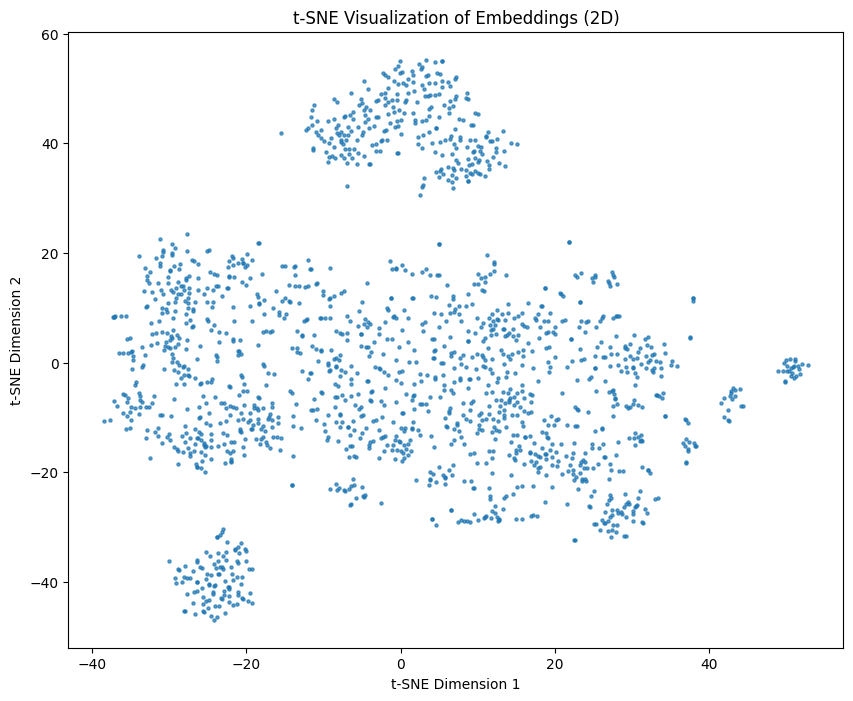

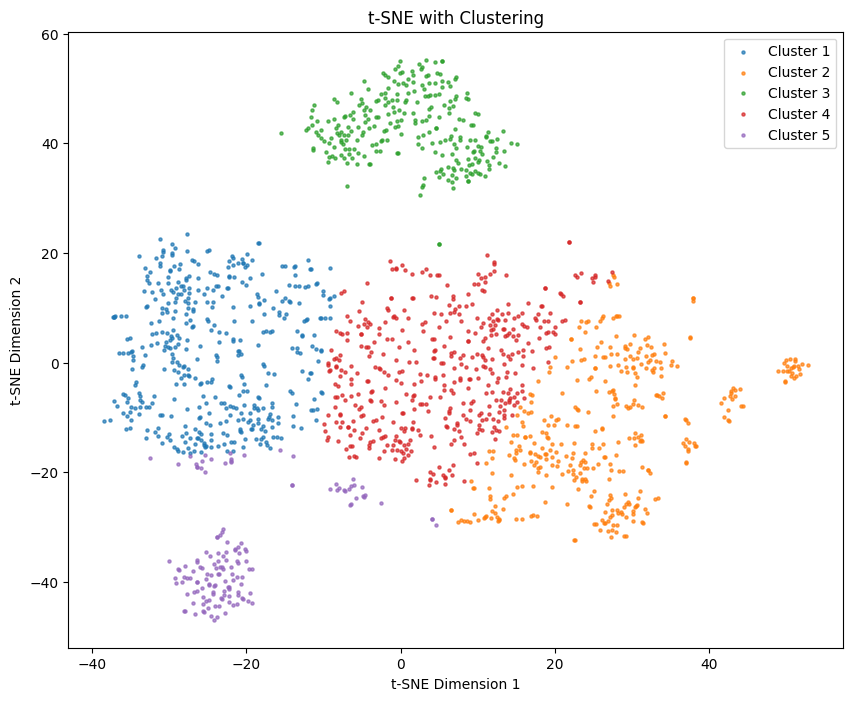

ValueError: too many values to unpack (expected 4)

<Figure size 1500x1000 with 0 Axes>

In [ ]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -------------------------
# Step 1: Load COCO Dataset
# -------------------------
class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        # Map image IDs to file names
        self.image_id_to_filename = {img['id']: img['file_name'] for img in self.coco_data['images']}
        self.annotations = self.coco_data['annotations']

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        bbox = annotation['bbox']  # COCO format: [x, y, width, height]
        file_name = self.image_id_to_filename[image_id]
        image_path = os.path.join(self.images_dir, file_name)

        # Load image and crop based on bbox
        image = Image.open(image_path).convert('RGB')
        x, y, w, h = map(int, bbox)
        cropped_image = image.crop((x, y, x + w, y + h))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, file_name, bbox

# Define dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "data/coco_datasets/test_data/test_images"
coco_json = "data/coco_datasets/test_data/test_annotations.json"
dataset = COCODataset(coco_json, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# -------------------------
# Step 2: Define ResNet Autoencoder
# -------------------------
class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetEncoder, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer
        self.fc = nn.Linear(512, embedding_dim)  # Adjust for ResNet18's output size

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(embedding_dim, 512 * 1 * 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 512, 1, 1)  # Reshape for ConvTranspose
        x = self.decoder(x)
        return x

class ResNetAutoencoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetAutoencoder, self).__init__()
        self.encoder = ResNetEncoder(embedding_dim)
        self.decoder = Decoder(embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Load model
embedding_dim = 128
model = ResNetAutoencoder(embedding_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Inference mode

# -------------------------
# Step 3: Extract Embeddings
# -------------------------
embeddings_list = []
valid_file_name_list = []
valid_bbox_list = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for images, file_names, bboxes in dataloader:
        images = images.to(device)
        _, embeddings = model(images)  # Get embeddings from encoder
        embeddings_list.append(embeddings.cpu().numpy())
        valid_file_name_list.extend(file_names)  # Track valid file names
        valid_bbox_list.extend(bboxes)  # Track valid bounding boxes

embeddings = np.vstack(embeddings_list)  # Combine all embeddings
print(f"Embeddings shape: {embeddings.shape}")

# -------------------------
# Step 4: Apply t-SNE
# -------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced_embeddings = tsne.fit_transform(embeddings)
print(f"t-SNE completed. Reduced embeddings shape: {reduced_embeddings.shape}")

# -------------------------
# Step 5: Visualize t-SNE Results
# -------------------------
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Embeddings (2D)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# -------------------------
# Step 6: Clustering (Optional)
# -------------------------
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=5, alpha=0.7, label=f"Cluster {cluster + 1}")
plt.legend()
plt.title("t-SNE with Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# -------------------------
# Step 7: Display Images in a Cluster
# -------------------------



In [ ]:
def show_cluster_images(cluster_id, cluster_labels, file_name_list, bbox_list, images_dir, max_images=20):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_indices = cluster_indices[:max_images]  # Limit to max_images

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(cluster_indices):
        try:
            file_name = file_name_list[idx]
            bbox = bbox_list[idx]
            image_path = os.path.join(images_dir, file_name)

            # Load and crop the image
            image = Image.open(image_path).convert('RGB')
            print(f"Sample bbox: {bbox}")
            x, y, w, h = map(int, bbox)


            cropped_image = image.crop((x, y, x + w, y + h))

            # Show the image
            plt.subplot(4, 5, i + 1)
            plt.imshow(cropped_image)
            plt.axis('off')
        except IndexError:
            print(f"Index {idx} out of range for cluster {cluster_id}.")
    plt.suptitle(f"Cluster {cluster_id} Images", fontsize=16)
    plt.show()

# Example: Show images in cluster 0
show_cluster_images(cluster_id=0, cluster_labels=cluster_labels, file_name_list=valid_file_name_list,
                    bbox_list=valid_bbox_list, images_dir=data_dir, max_images=20)


Sample bbox: tensor([634.1200, 301.3100, 319.7600, 760.2900, 538.2700, 632.3400, 482.9000,
        584.7100,  15.5300, 362.9600, 530.5300, 348.3400, 785.9500, 698.2700,
        785.9500, 748.0900, 458.4900, 458.6100, 668.2800, 854.5300, 139.4900,
        858.3300, 617.5700, 987.3000, 809.4900, 924.1900, 718.7800, 597.3300,
          0.0000, 801.5400, 626.8500, 886.1900], dtype=torch.float64)


ValueError: too many values to unpack (expected 4)

<Figure size 1500x1000 with 0 Axes>